In [461]:
options(repr.plot.width = 1, repr.plot.height = 0.75)
options(repr.plot.width=4, repr.plot.height=4)
getwd() #activate R_time. install rstan and rethinking(experimental) in env.
#.libPaths()
#.libPaths("C:/Users/hvill/Anaconda3/envs/R_time/Lib/R/library")
#.libPaths()
#.libPaths('C:/Users/hvill/Documents/R/win-library/3.3')
.libPaths()

[1] "C:/Users/hvill/statrethinking_winter2019/homework"

[1] "C:/Users/hvill/Documents/R/win-library/3.3"
[2] "C:/Program Files/R/R-3.3.1/library"

In [462]:
library(rethinking)

# Question 1
- Suppose the globe tossing data had turned out to be 8 water in 15 tosses.
- Construct the posterior distribution, using **grid approximation**.
- Use the same **flat prior** as before.

### Thoughts:
- Flat prior means a uniform distribution. Uniform Density plot is a straight "flat" line.
- All of the proposed probabilities (in this case proportion of water) are equally plausible.
- Plausible - number of ways that the data can be generated by the probability.
- quap() uses 2nd order partial derivatives (Hessian) to approx curvature of posterior distrubtion.
- dbeta(alpah=hits, beta=misses)
    

### Using Quadratic Approximation
- bernoulli
- binomial

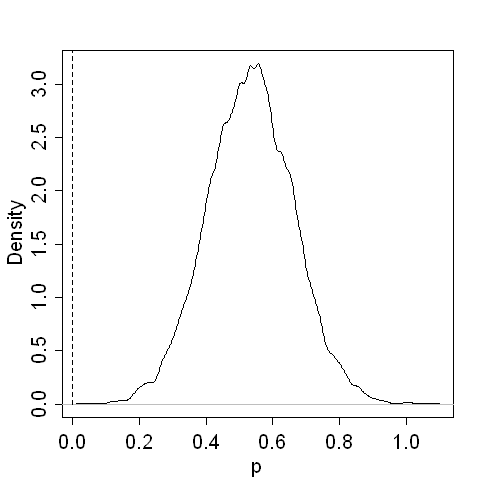

In [463]:
# build model
flist <- alist(
    w ~ dbern(p) , #observed variable. likelihood.
    p ~ dunif(0,1)  #unobserved variable. prior.
)

# get the posterior by fitting the model with quap(), quadratic approx. 
bern.model <- quap(flist = flist, data =list(w=data)) 

# extract samples to work with full posterior.
bern.posterior <- extract.samples(bern.model, n=1e4)
dens(bern.posterior)

We used the bernoulli distribution because each
row in the data is 1 trial of 1 or 0 (water or no water).
It has only one parameter which is probability/proportion
of water on the globe. This will be our posrteriour distriburion.

rbinom would work here if the data had only one value 8.
from the information given in the question.
1 trial of 15 tosses with 8 water.

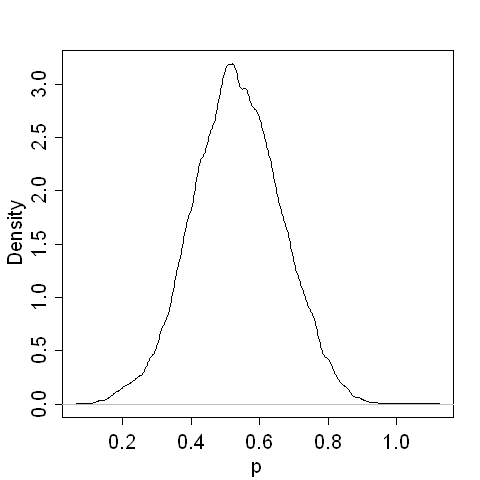

In [464]:
# build model
flist <- alist(
    w ~ dbinom(size=15, prob = p) , #observed variable. likelihood.
    p ~ dunif(0,1)  #unobserved variable. prior.
)

# get the posterior by fitting the model with quap(), quadratic approx.
binom.model <- quap(flist = flist, data =list(w=8)) 

# extract samples to work with full posterior.
binom.posterior <- extract.samples(binom.model, n=1e4)
dens(binom.posterior)

### Using Grid Approximation
- Maximum Likelihood
- Bayes Grid Approximation

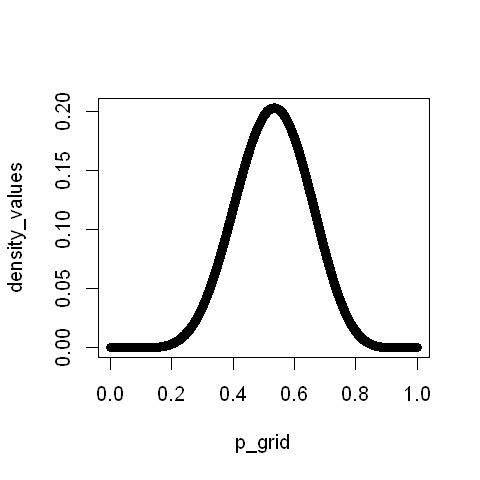

In [465]:
p_grid <- seq(0,1,length.out = 10000)
density_values <- dbinom(x = 8, size = 15, prob = p_grid)
plot(p_grid, density_values)

,p_grid,density_values
5334,0.5333533,0.203042


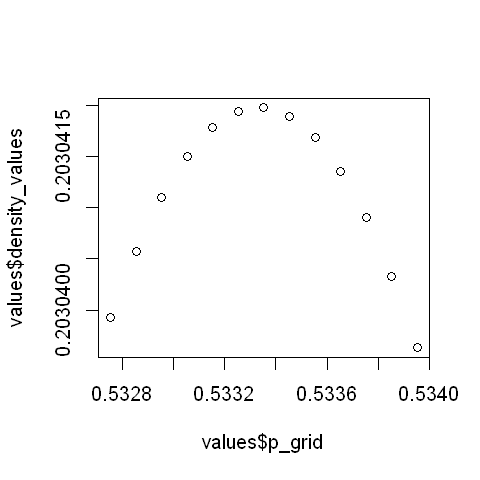

In [466]:
max_density <- max(density_values)

values <- data.frame(p_grid,density_values)
values[values$density_values==max_density,]

# distribution peak
values <- values[5328:5340,]
plot(values$p_grid, values$density_values)

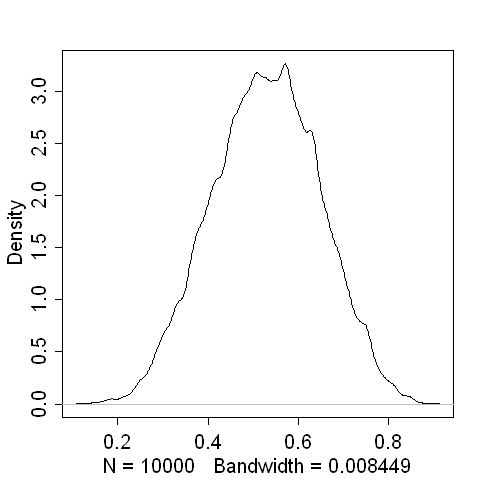

In [495]:
# grid approximation
p_grid <- seq( from=0 , to=1 , length.out=1000 ) # these are p values we will consider.
prior <- rep( 1 , 1000 ) #Flat prior  # Uniform between 0 1
prob_data <- dbinom( 8 , size=15 , prob=p_grid )
posterior <- prob_data * prior # To get posterior we standardize.
posterior <- posterior / sum(posterior) # This is the posterior.
set.seed(100)
flat_prior.posterior <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )
dens(flat_prior.posterior)

# Question 2
- Start over in 1, but now use a prior that is zero below p=0.5 and a constant above p=0.5.
- This corresponds to prior information that a majority of the Earth’s surface is water.
- What difference does the better prior make?
- If it helps, compare posterior distributions (using both priors) to the true value p=0.7

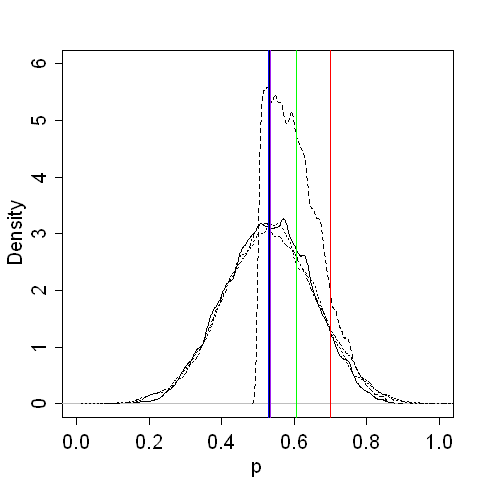

In [548]:
# In the problem, a constant means 1.
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- c( rep( 0 , 500 ) , rep( 1 , 500 ) )
prob_data <- dbinom( 8 , size=15 , prob=p_grid )
posterior <- prob_data * prior
posterior <- posterior / sum(posterior)
set.seed(100)
constant_above_p5_prior.posterior <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )
dens( flat_prior.posterior , xlab="p" , xlim=c(0,1) , ylim=c(0,6) )
dens( constant_above_p5_prior.posterior , add=TRUE , lty=2 )
dens( bern.posterior[['p']] , add=TRUE , lty=3 )
dens( binom.posterior[['p']] , add=TRUE , lty=4 )

abline( v=0.7 , col="red" )
abline( v=mean(flat_prior.posterior) , col="blue" )
abline( v=mean(constant_above_p5_prior.posterior) , col="green" )
abline( v=mean(bern.posterior[['p']]) , col="black" )
abline( v=mean(binom.posterior[['p']]) , col="purple" )

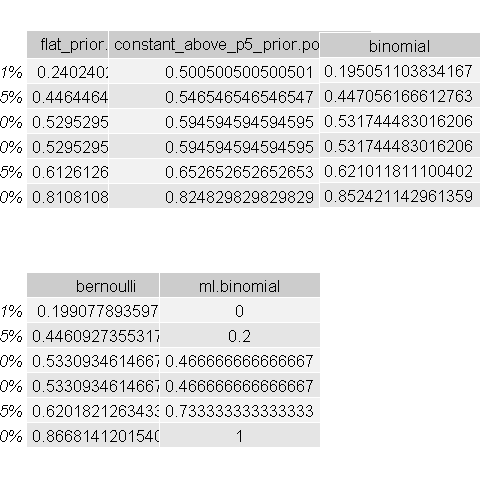

In [830]:
library(gridExtra)

tt <- ttheme_default(colhead=list(fg_params = list(parse=TRUE)),
                      padding = unit(c(.1, .1), "in"), 
                      base_size = 10)

flat <- tableGrob(PI( flat_prior.posterior , c(0,0.5,0.99)),
                 rows= c('1%','25%','50%','50%','75%','100%'),
                 cols = c('flat_prior.posterior'),
                 theme=tt)

gtr5 <- tableGrob(PI( constant_above_p5_prior.posterior, c(0,0.5,0.99)),
                 # rows= c('1%','25%','50%','50%','75%','100%'),
                  cols = c('constant_above_p5_prior.posterior'),
                  theme=tt)

bern <- tableGrob(PI(bern.posterior[['p']],c(0,0.5,0.99)),
                 rows= c('1%','25%','50%','50%','75%','100%'),
                 cols =c('bernoulli'),
                 theme=tt)

binom <- tableGrob(PI(binom.posterior[['p']], c(0,0.5,0.99)),
                 #rows= c('1%','25%','50%','50%','75%','100%'),
                 cols = 'binomial',
                 theme=tt)
 
ml.binom <- tableGrob(PI( rbinom(n = 1000,size = 15, prob = p_grid)/15,
                         c(0,0.5,0.99)),
                # rows= c('1%','25%','50%','50%','75%','100%'),
                 cols = 'ml.binomial',
                 theme=tt)

grid.arrange( flat, gtr5, binom, bern, ml.binom, ncol=3, nrow=2)

# grid.show.layout(grid.layout(4, 4, widths = unit(c(3, 1, 1, 1),
#                               c("lines", "null", "null", "cm")),
#                               heights = c(1, 1, 1, 1),
#                               c("cm", "null", "null", "lines")))

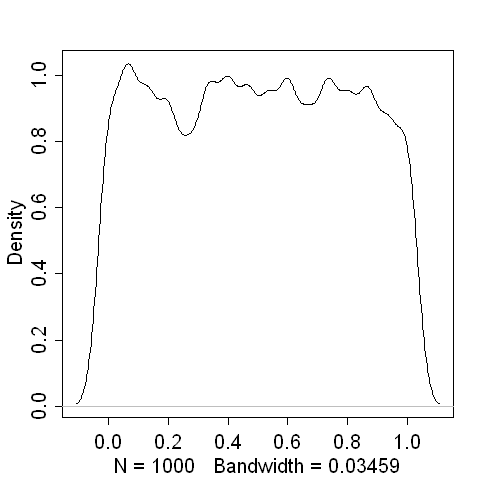

In [831]:
dens(d)

# Question 3
- Suppose you want to estimate the Earth’s proportion of
water very precisely.
- Specifically, you want the 99% percentile interval of the
posterior distribution of p to be only 0.05 wide.
- This means the distance between the upper and lower bound of the interval should be 0.05.
- How many times will you have to toss the globe to do this?
- I won’t require a precise answer. I’m honestly more interested in your approach.

### Thoughts:
- This works because we know p true. 

In [566]:
set.seed(100)

width <- function(N) {
#N <- 2000#100 #20
p_true <- 0.7
W <- rbinom( 1 , size=N , prob=p_true )
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep( 1 , 1000 )
prob_data <- dbinom( W , size=N , prob=p_grid )
posterior <- prob_data * prior
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )
PI99 <- PI( samples , 0.99 )
as.numeric( PI99[2] - PI99[1] )
}

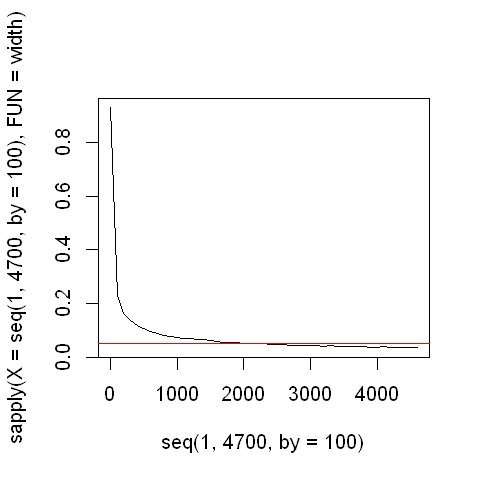

In [602]:
plot(x = seq(1, 4700, by = 100),
     y = sapply(X = seq(1, 4700, by = 100), FUN = width),
     type = 'l')
abline(h = 0.05, col = 'red')

In [675]:
wid <- data.frame(N = seq(1, 4700, by = 100),
            k = sapply(X = seq(1, 4700, by = 100), FUN = width),
            abs.diff = abs(sapply(X = seq(1, 4700, by = 100), FUN = width)-0.05)
)

# Need about 2,101 tosses to get within 5% difference 99% interval.
wid[wid$abs.diff==min(wid$abs.diff),]

wid[wid$abs.diff>=min(wid$abs.diff)-0.005 & wid$abs.diff<=min(wid$abs.diff)+0.005,]

,N,k,abs.diff
22,2101,0.05005005,5.005005e-05


,N,k,abs.diff
20,1901,0.05405405,4.054054e-03
21,2001,0.05205205,2.052052e-03
22,2101,0.05005005,5.005005e-05
23,2201,0.04904905,2.052052e-03
24,2301,0.04904905,9.509510e-04
25,2401,0.04804805,1.951952e-03
26,2501,0.04704705,1.951952e-03
27,2601,0.04704705,2.952953e-03
28,2701,0.04504505,4.954955e-03


In [832]:
getwd()

[1] "C:/Users/hvill/statrethinking_winter2019/homework"